Some conversion notes
For huffpost, if you want to see the charts:
https://elections.huffingtonpost.com/pollster/2016-general-election-trump-vs-clinton
if you want to get the data, tack .csv at the end.
https://elections.huffingtonpost.com/pollster/2016-general-election-trump-vs-clinton.csv



Answer the following questions:
- Who was being polled and what was their party affiliation?
- Did the poll results favor Romney or Obama?
- How do undecided voters effect the poll?
- Can we account for the undecided voters?
- How did voter sentiment change over time?
- Can we see an effect in the polls from the debates?

In [109]:
# Imports
from __future__ import division
# For data
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import requests
from io import StringIO
from datetime import datetime

In [110]:
# URL link
url = "http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv"

# convert the .csv to text type
source = requests.get(url).text

poll_data = StringIO(source)
poll_df = pd.read_csv(poll_data)

In [111]:
poll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 17 columns):
Pollster                  586 non-null object
Start Date                586 non-null object
End Date                  586 non-null object
Entry Date/Time (ET)      586 non-null object
Number of Observations    564 non-null float64
Population                586 non-null object
Mode                      586 non-null object
Obama                     586 non-null float64
Romney                    586 non-null float64
Undecided                 423 non-null float64
Other                     202 non-null float64
Pollster URL              586 non-null object
Source URL                584 non-null object
Partisan                  586 non-null object
Affiliation               586 non-null object
Question Text             0 non-null float64
Question Iteration        586 non-null int64
dtypes: float64(6), int64(1), object(10)
memory usage: 77.9+ KB


In [112]:
poll_df.head(3)

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1


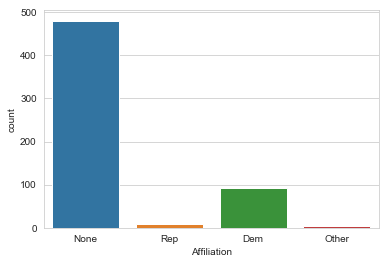

In [113]:
# What is affiliation
sns.countplot('Affiliation',data=poll_df)

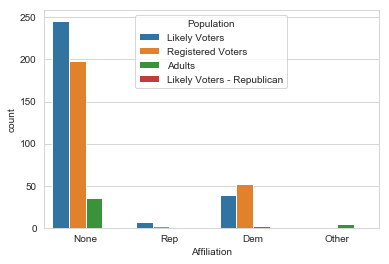

In [114]:
# Affiliation by population
sns.countplot('Affiliation',data=poll_df,hue='Population')

Looks like we have a strong showing of likely voters and Registered Voters, so the poll data should hopefully be a good reflection on the populations polled.

averages for Obama, Romney , and the polled people who remained undecided.

In [115]:
poll_df.mean().head(3)

Number of Observations    1296.679078
Obama                       46.805461
Romney                      44.614334
dtype: float64

In [116]:
# get the mean, drop the number of observations, Question Text and Question Iteration to focus the data
avg = pd.DataFrame(poll_df.mean()) 
avg.drop(['Question Text','Question Iteration','Number of Observations'],axis=0,inplace=True)

In [117]:
# get the stddev, also dropping number of obserations
std = pd.DataFrame(poll_df.std())
std.drop(['Question Text','Question Iteration','Number of Observations'],axis=0,inplace=True)

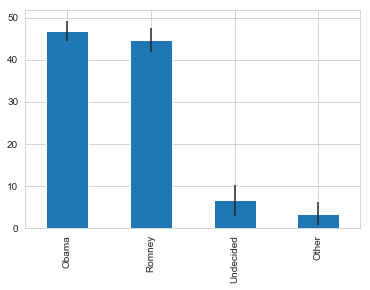

In [118]:
# now plot avg with yerr=stddev
avg.plot(yerr=std,kind='bar',legend=False)

The polls seem very close, given undecideds. Check out the numbers

In [119]:
# Concatenate our Average and Std DataFrames
poll_avg = pd.concat([avg,std],axis=1)

#Rename columns
poll_avg.columns = ['Average','STD']

#Show
poll_avg

,Average,STD
Obama,46.805461,2.422058
Romney,44.614334,2.906180
Undecided,6.550827,3.701754
Other,3.376238,2.692726


Looks like the polls indicate a fairly close race. But what about the undecided voters? Most of them will likely vote for one of the candidates once the election occurs. Let's assume that if we split the undecided evenly between the two candidates the observed difference should be an unbiased estimate of the final difference.

In [120]:
poll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 17 columns):
Pollster                  586 non-null object
Start Date                586 non-null object
End Date                  586 non-null object
Entry Date/Time (ET)      586 non-null object
Number of Observations    564 non-null float64
Population                586 non-null object
Mode                      586 non-null object
Obama                     586 non-null float64
Romney                    586 non-null float64
Undecided                 423 non-null float64
Other                     202 non-null float64
Pollster URL              586 non-null object
Source URL                584 non-null object
Partisan                  586 non-null object
Affiliation               586 non-null object
Question Text             0 non-null float64
Question Iteration        586 non-null int64
dtypes: float64(6), int64(1), object(10)
memory usage: 77.9+ KB


Here's a messy time series analysis of the voter sentiment by plotting Obama/Romney favor versus the Poll End Date

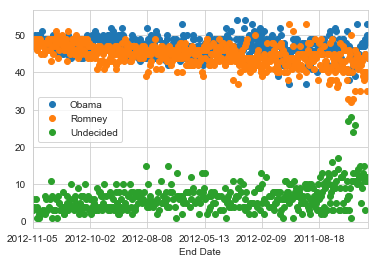

In [121]:
# This is reversed - RHS is earlier - LHS is later:
poll_df.plot(x='End Date',y=['Obama','Romney','Undecided'],marker='o',linestyle='')

#### Create a new feature to feature the difference between Romney and Obama in the polls

The Difference column is Obama minus Romney, thus a positive difference indicates a leaning towards Obama in the polls.

In [122]:
poll_df['Difference'] = (poll_df.Obama - poll_df.Romney)/100
poll_df.head(3)

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,Difference
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1,0.00
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1,0.02
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1,0.00


 Now to visualize how sentiment in difference changes over time

In [123]:
poll_df = poll_df.groupby(['Start Date'],as_index=False).mean()

poll_df.head(3)

,Start Date,Number of Observations,Obama,Romney,Undecided,Other,Question Text,Question Iteration,Difference
0,2009-03-13,1403.0,44.0,44.0,12.0,NaN,NaN,1,0.00
1,2009-04-17,686.0,50.0,39.0,11.0,NaN,NaN,1,0.11
2,2009-05-14,1000.0,53.0,35.0,12.0,NaN,NaN,1,0.18


positive difference indicates a leaning towards Obama

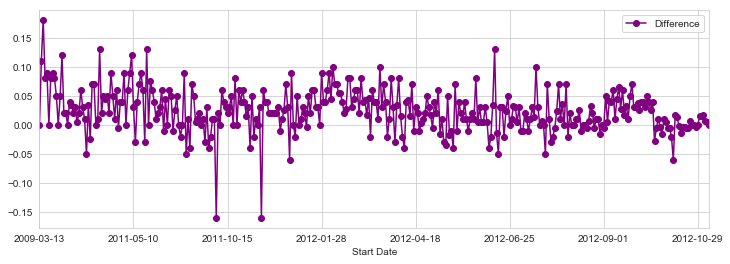

In [124]:
fig = poll_df.plot('Start Date','Difference',figsize=(12,4),marker='o',linestyle='-',color='purple')

Plotting marker lines on the dates of the debates and see if there is adds insight. The debate dates were Oct 3rd, Oct 11, and Oct 22nd. Let's plot some lines as markers and then zoom in on the month of October.

In order to find where to set the x limits for the figure we need to find out where the index for the month of October in 2012 is.

In [125]:
# Set row count and xlimit list
row_in = 0
xlimit = []

# Cycle through dates until 2012-10 is found, then print row index
for date in poll_df['Start Date']:
    if date[0:7] == '2012-10':
        xlimit.append(row_in)
        row_in +=1
    else:
        row_in += 1
        
print(min(xlimit))
print(max(xlimit))

325
352


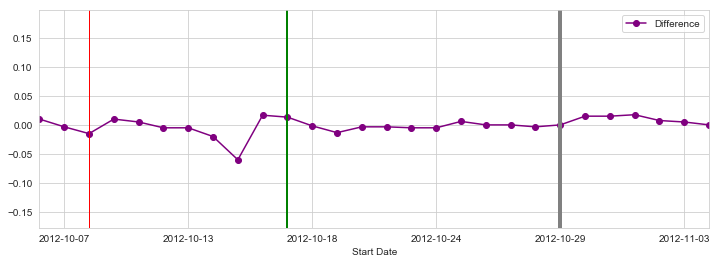

In [126]:
fig = poll_df.plot('Start Date','Difference',figsize=(12,4),marker='o',linestyle='-',color='purple',xlim=(329,356))

# Debate on Oct 3 (Oct 1 + 2)
plt.axvline(x=329+2, linewidth=1, color='red')
# Debate on Oct 11 (Oct 1 + 10)
plt.axvline(x=329+10, linewidth=2, color='green')
# Debate on Oct 22 (Oct 1 + 21)
plt.axvline(x=329+21, linewidth=4, color='grey')

## Donor Analysis

Questions to answer:

- How much was donated and what was the average donation?
- How did the donations differ between candidates?
- How did the donations differ between Democrats and Republicans?
- What were the demographics of the donors?
- Is there a pattern to donation amounts?

In [127]:
donor_df = pd.read_csv('Election_Donor_Data.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [128]:
donor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


In [129]:
donor_df.head(3)

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073


What sorts of amounts are we dealing with?

In [130]:
donor_df['contb_receipt_amt'].value_counts().head()

100.0    178188
50.0     137584
25.0     110345
250.0     91182
500.0     57984
Name: contb_receipt_amt, dtype: int64

How many in total?

In [131]:
donor_df['contb_receipt_amt'].value_counts().count()

8079

In [132]:
# mean donation and stddev donation
don_mean = round(donor_df['contb_receipt_amt'].mean(),2)
don_std = round(donor_df['contb_receipt_amt'].std(),2)

In [133]:
print(f'The average donation was {don_mean} with a std of {don_std}')

The average donation was 298.24 with a std of 3749.67


3749.67 is huge for a StdDev. Are large donations or other factors messing with the distribution?

In [134]:
top_donor = donor_df['contb_receipt_amt'].copy()
top_donor.sort_values(ascending=False, inplace=True)
top_donor.head(3)

325136    2014490.51
326651    1944042.43
344539    1679114.65
Name: contb_receipt_amt, dtype: float64

 The negative values are due to the FEC recording refunds as well as donations - fixing to only look at positive donation amounts
 

In [135]:
# Get rid of the negative values
top_donor = top_donor[top_donor >0]

top_donor.sort_values(ascending=False, inplace=True)

# Look at the top 10 most common donations value counts
top_donor.value_counts().head(10)

100.0     178188
50.0      137584
25.0      110345
250.0      91182
500.0      57984
2500.0     49005
35.0       37237
1000.0     36494
10.0       33986
200.0      27813
Name: contb_receipt_amt, dtype: int64

Ranging from `$10`-`$2500`. Are usually made in round number amounts? It appears so, though it would be useful to get better x values for the <`$100` amounts.

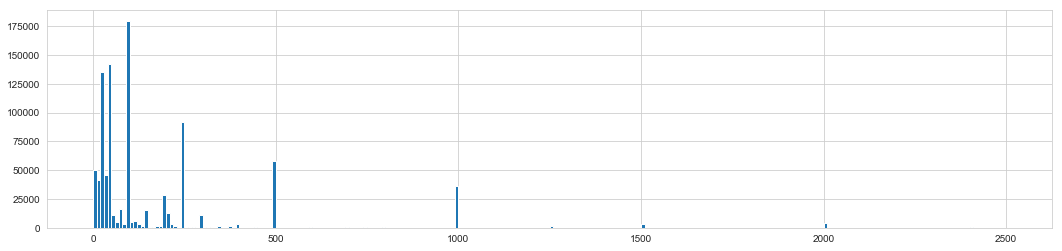

In [136]:
com_don = top_donor[top_donor < 2500]

# Set a high number of bins to account for the non-round donations and check histogram for spikes.
# figsize (width,height)
com_don.hist(bins=250,figsize=(18,4))

How about donations by Party

In [137]:
# Get a list of Candidates
candidates = donor_df.cand_nm.unique()
candidates

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [138]:
# Break them out by party affiliation
# Dictionary of party affiliation
party_map = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

donor_df['Party'] = donor_df.cand_nm.map(party_map)

In [139]:
donor_df.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,Party
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073,Republican
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.24548e+08,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073,Republican
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.19016e+08,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican


In [140]:
# Clear refunds from Candidates
donor_df = donor_df[donor_df.contb_receipt_amt >0]


In [141]:
donor_df.groupby('cand_nm')['contb_receipt_amt'].count()

cand_nm
Bachmann, Michelle                 13082
Cain, Herman                       20052
Gingrich, Newt                     46883
Huntsman, Jon                       4066
Johnson, Gary Earl                  1234
McCotter, Thaddeus G                  73
Obama, Barack                     589127
Paul, Ron                         143161
Pawlenty, Timothy                   3844
Perry, Rick                        12709
Roemer, Charles E. 'Buddy' III      5844
Romney, Mitt                      105155
Santorum, Rick                     46245
Name: contb_receipt_amt, dtype: int64

In [142]:
donor_df.groupby('cand_nm')['contb_receipt_amt'].sum()

cand_nm
Bachmann, Michelle                2.711439e+06
Cain, Herman                      7.101082e+06
Gingrich, Newt                    1.283277e+07
Huntsman, Jon                     3.330373e+06
Johnson, Gary Earl                5.669616e+05
McCotter, Thaddeus G              3.903000e+04
Obama, Barack                     1.358774e+08
Paul, Ron                         2.100962e+07
Pawlenty, Timothy                 6.004819e+06
Perry, Rick                       2.030575e+07
Roemer, Charles E. 'Buddy' III    3.730099e+05
Romney, Mitt                      8.833591e+07
Santorum, Rick                    1.104316e+07
Name: contb_receipt_amt, dtype: float64

In [143]:
# Start by setting the groupby as an object
cand_amount = donor_df.groupby('cand_nm')['contb_receipt_amt'].sum()

# Our index tracker
i = 0

for don in cand_amount:
    print(f"The candidate {cand_amount.index[i]} raised {round(don):,} dollars")
    i += 1

The candidate Bachmann, Michelle raised 2,711,439 dollars
The candidate Cain, Herman raised 7,101,082 dollars
The candidate Gingrich, Newt raised 12,832,770 dollars
The candidate Huntsman, Jon raised 3,330,373 dollars
The candidate Johnson, Gary Earl raised 566,962 dollars
The candidate McCotter, Thaddeus G raised 39,030 dollars
The candidate Obama, Barack raised 135,877,427 dollars
The candidate Paul, Ron raised 21,009,620 dollars
The candidate Pawlenty, Timothy raised 6,004,819 dollars
The candidate Perry, Rick raised 20,305,754 dollars
The candidate Roemer, Charles E. 'Buddy' III raised 373,010 dollars
The candidate Romney, Mitt raised 88,335,908 dollars
The candidate Santorum, Rick raised 11,043,159 dollars


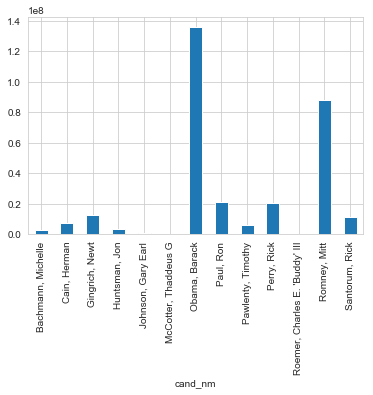

In [144]:
# Visualizing totals
cand_amount.plot(kind='bar')

What about raw Republican vs Democratic donations

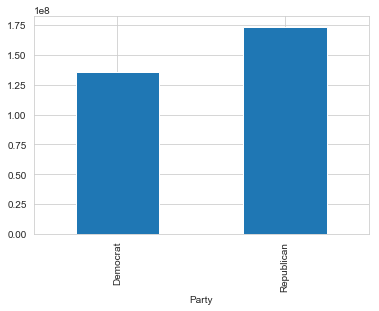

In [145]:
# Groupby party and then count donations
donor_df.groupby('Party')['contb_receipt_amt'].sum().plot(kind='bar')

How about Donor Occupation?

In [146]:
# Use a pivot table to extract and organize the data by the donor occupation
occupation_df = donor_df.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='Party', aggfunc='sum')

In [147]:
occupation_df.head()

Party,Democrat,Republican
contbr_occupation,,
MIXED-MEDIA ARTIST / STORYTELLER,100.0,NaN
AREA VICE PRESIDENT,250.0,NaN
RESEARCH ASSOCIATE,100.0,NaN
TEACHER,500.0,NaN
THERAPIST,3900.0,NaN


How many different occupations?


In [148]:
occupation_df.shape

(45067, 2)

45k is going to be too big to view. Need something narrowed down enough to visualize. 

In [150]:
# Set a cut off point at 1 milllion dollars of sum contributions
occupation_df = occupation_df[occupation_df.sum(1) > 1000000]

In [151]:
occupation_df.head(3)

Party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.43
BANKER,224084.40,1259468.73
BUSINESS OWNER,449979.30,1323342.43


In [152]:
occupation_df.shape

(31, 2)

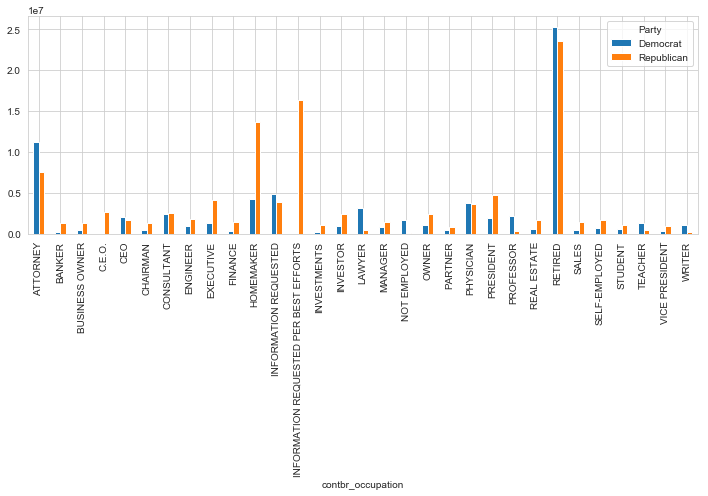

In [153]:
occupation_df.plot(kind='bar',figsize=(12,4))

Flipping the chart horizontally for easier reading

In [ ]:
# Horizontal plot, use a convienently colored cmap
occupation_df.plot(kind='barh',figsize=(10,12),cmap='seismic')

In [ ]:
# Drop the unavailble occupations
occupation_df.drop(['INFORMATION REQUESTED PER BEST EFFORTS','INFORMATION REQUESTED'],axis=0,inplace=True)

In [ ]:
occupation_df.plot(kind='barh',figsize=(10,12),cmap='seismic')

Combining C.E.O variations

In [ ]:
# Set new ceo row as sum of the current two
occupation_df.loc['CEO'] = occupation_df.loc['CEO'] + occupation_df.loc['C.E.O.']
# Drop CEO
occupation_df.drop('C.E.O.',inplace=True)

In [ ]:
occupation_df.plot(kind='barh',figsize=(10,12),cmap='seismic')